# Music Recommendation

In [42]:
# Load Python libraries
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
from sklearn.ensemble import RandomForestClassifier

In [4]:

# Load data
df = pd.read_csv('F:/letsgrow/New folder/train.csv')

# 1% sample of items
df = df.sample(frac=0.01)

In [5]:
# Load and join songs data
songs = pd.read_csv('F:/letsgrow/New folder/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and join songs data
members = pd.read_csv('F:/letsgrow/New folder/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [7]:
df.head().T

,0,1,2,3,4
msno,p0VUTWmw14w0Df5UR4tv8V4hbfGxTXQnecpGuHc+8CA=,jxkrRpndZIzzm/8J5LwR+SZ9/GeNWOcBTVY1zC5eqEQ=,hlogRVyvO6+GMMhsBS8r0JCwiAlbzjLNXJfEJJrRq/0=,u3gyatnFixkpH1jEGO4Y+p4qUc0WYd7t6svNBAx48h0=,YalJ9Q+msl3FB3wK7VHMsJDSfAfhld2yt5lSHNQeHc0=
song_id,zaKUhTDTh+rgThsPJX1iWC4x+6sEJBzR8tSdgp5ySXs=,QjRlzbxmVxusW6CP2Xr8GjX3BnPitUMFBxCWxd/5AKY=,RMh/AFwd3LVJYTO7BKVBcvl+6vyMWUED4BQ4IquMLik=,oRGOOUXeV11gPOlhaPW2/bBRgRPHE1sbhSgVmKprJYU=,CIe8eiKAnJqpbvB6fBgY0WNUsttrMYkSYGOq5k8nDh4=
source_system_tab,search,discover,radio,discover,my library
source_screen_name,Album more,Online playlist more,Radio,NaN,Local playlist more
source_type,album,online-playlist,radio,song-based-playlist,local-playlist
target,0,0,0,1,0
song_length,315515,231363,211539,213002,231456
genre_ids,458,465,465,465,1259
artist_name,王力宏 (Leehom Wang),Maroon 5,Jess Glynne,Dizzy Dizzo,Pitbull
composer,Leehom Wang,Adam Levine| Johan Karl Schuster| Benjamin Lev...,J. Glynne| F. Dow-Smith| J. Bennett| K. Brown,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73774 entries, 0 to 73773
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msno                    73774 non-null  object 
 1   song_id                 73774 non-null  object 
 2   source_system_tab       73554 non-null  object 
 3   source_screen_name      69574 non-null  object 
 4   source_type             73576 non-null  object 
 5   target                  73774 non-null  int64  
 6   song_length             73774 non-null  int64  
 7   genre_ids               72617 non-null  object 
 8   artist_name             73774 non-null  object 
 9   composer                57223 non-null  object 
 10  lyricist                42067 non-null  object 
 11  language                73773 non-null  float64
 12  city                    73774 non-null  int64  
 13  bd                      73774 non-null  int64  
 14  gender                  44442 non-null

In [9]:
df.describe()

,target,song_length,language,city,bd,registered_via,registration_init_time,expiration_date
count,73774.000000,7.377400e+04,73773.000000,73774.000000,73774.000000,73774.000000,7.377400e+04,7.377400e+04
mean,0.506588,2.449478e+05,18.599000,7.533115,17.641730,6.794765,2.012788e+07,2.017159e+07
std,0.499960,6.646828e+04,21.193096,6.628614,20.856442,2.281331,3.025640e+04,3.907246e+03
min,0.000000,6.087000e+03,-1.000000,1.000000,-43.000000,3.000000,2.004033e+07,2.004102e+07
25%,0.000000,2.148310e+05,3.000000,1.000000,0.000000,4.000000,2.011063e+07,2.017091e+07
50%,1.000000,2.415800e+05,3.000000,5.000000,21.000000,7.000000,2.013102e+07,2.017093e+07
75%,1.000000,2.719860e+05,52.000000,13.000000,29.000000,9.000000,2.015102e+07,2.017101e+07
max,1.000000,7.575835e+06,59.000000,22.000000,1030.000000,13.000000,2.017013e+07,2.020102e+07


## Impute missing data

In [10]:
# Count Na in %
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.298208
source_screen_name         5.693063
source_type                0.268387
target                     0.000000
song_length                0.000000
genre_ids                  1.568303
artist_name                0.000000
composer                  22.434733
lyricist                  42.978556
language                   0.001355
city                       0.000000
bd                         0.000000
gender                    39.759265
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [11]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [12]:
df.isnull().sum()/df.isnull().count()*100

msno                      0.0
song_id                   0.0
source_system_tab         0.0
source_screen_name        0.0
source_type               0.0
target                    0.0
song_length               0.0
genre_ids                 0.0
artist_name               0.0
composer                  0.0
lyricist                  0.0
language                  0.0
city                      0.0
bd                        0.0
gender                    0.0
registered_via            0.0
registration_init_time    0.0
expiration_date           0.0
dtype: float64

In [13]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [14]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,p0VUTWmw14w0Df5UR4tv8V4hbfGxTXQnecpGuHc+8CA=,zaKUhTDTh+rgThsPJX1iWC4x+6sEJBzR8tSdgp5ySXs=,search,Album more,album,0,315515,458,王力宏 (Leehom Wang),Leehom Wang,...,female,9,2004-03-29,2018-05-04,2004,3,29,2018,5,4
1,jxkrRpndZIzzm/8J5LwR+SZ9/GeNWOcBTVY1zC5eqEQ=,QjRlzbxmVxusW6CP2Xr8GjX3BnPitUMFBxCWxd/5AKY=,discover,Online playlist more,online-playlist,0,231363,465,Maroon 5,Adam Levine| Johan Karl Schuster| Benjamin Lev...,...,male,9,2004-12-01,2017-09-25,2004,12,1,2017,9,25
2,hlogRVyvO6+GMMhsBS8r0JCwiAlbzjLNXJfEJJrRq/0=,RMh/AFwd3LVJYTO7BKVBcvl+6vyMWUED4BQ4IquMLik=,radio,Radio,radio,0,211539,465,Jess Glynne,J. Glynne| F. Dow-Smith| J. Bennett| K. Brown,...,female,9,2008-07-12,2017-10-05,2008,7,12,2017,10,5
3,u3gyatnFixkpH1jEGO4Y+p4qUc0WYd7t6svNBAx48h0=,oRGOOUXeV11gPOlhaPW2/bBRgRPHE1sbhSgVmKprJYU=,discover,unknown,song-based-playlist,1,213002,465,Dizzy Dizzo,unknown,...,unknown,9,2015-06-20,2017-12-02,2015,6,20,2017,12,2
4,YalJ9Q+msl3FB3wK7VHMsJDSfAfhld2yt5lSHNQeHc0=,CIe8eiKAnJqpbvB6fBgY0WNUsttrMYkSYGOq5k8nDh4=,my library,Local playlist more,local-playlist,0,231456,1259,Pitbull,unknown,...,female,9,2014-01-05,2017-09-25,2014,1,5,2017,9,25


In [15]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [16]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

In [40]:
df.corr()

,msno,song_id,source_screen_name,source_type,song_length,artist_name,composer,bd,registration_init_time,registration_init_time_month,registration_init_time_day,expiration_date_day
msno,1.000000,0.003110,-0.006508,-0.002596,0.001385,0.004857,0.005888,-0.003529,0.003679,0.011254,0.015910,0.007537
song_id,0.003110,1.000000,0.002989,0.002296,-0.014158,-0.025731,-0.035504,-0.006686,0.004227,-0.000852,0.000203,0.007357
source_screen_name,-0.006508,0.002989,1.000000,0.402692,0.015650,0.014845,0.014872,-0.009807,0.036126,0.002627,0.005289,-0.003786
source_type,-0.002596,0.002296,0.402692,1.000000,0.012856,-0.011910,-0.000626,-0.010438,0.036467,0.010053,0.003790,-0.008692
song_length,0.001385,-0.014158,0.015650,0.012856,1.000000,0.121716,0.101287,0.004342,-0.008307,0.007303,-0.000986,-0.003854
artist_name,0.004857,-0.025731,0.014845,-0.011910,0.121716,1.000000,0.349818,0.012658,-0.013026,0.003955,-0.000777,-0.001495
composer,0.005888,-0.035504,0.014872,-0.000626,0.101287,0.349818,1.000000,0.009414,-0.009295,0.008737,-0.003067,0.001445
bd,-0.003529,-0.006686,-0.009807,-0.010438,0.004342,0.012658,0.009414,1.000000,-0.340906,-0.014992,-0.002724,0.035955
registration_init_time,0.003679,0.004227,0.036126,0.036467,-0.008307,-0.013026,-0.009295,-0.340906,1.000000,0.061471,-0.029609,-0.071625
registration_init_time_month,0.011254,-0.000852,0.002627,0.010053,0.007303,0.003955,0.008737,-0.014992,0.061471,1.000000,0.037059,-0.008153


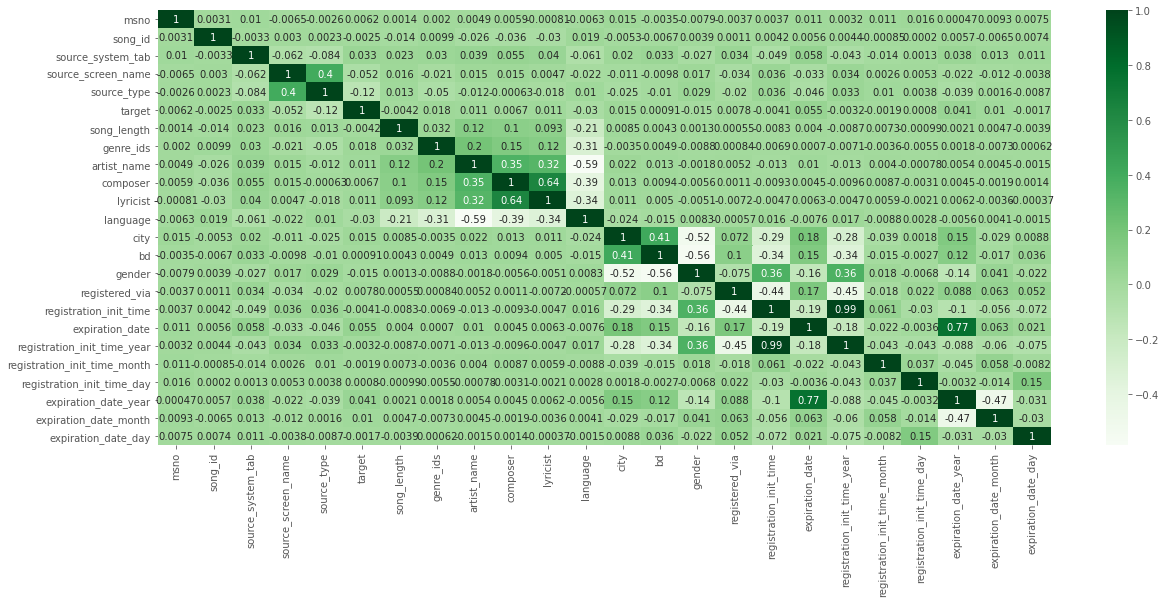

In [22]:
# Сorrelation matrix
plt.figure(figsize=[20,8])
sns.heatmap(df.corr(),annot=True, cmap="Greens")
plt.show()

In [23]:
# Drop columns
df = df.drop(['expiration_date', 'lyricist'], 1)

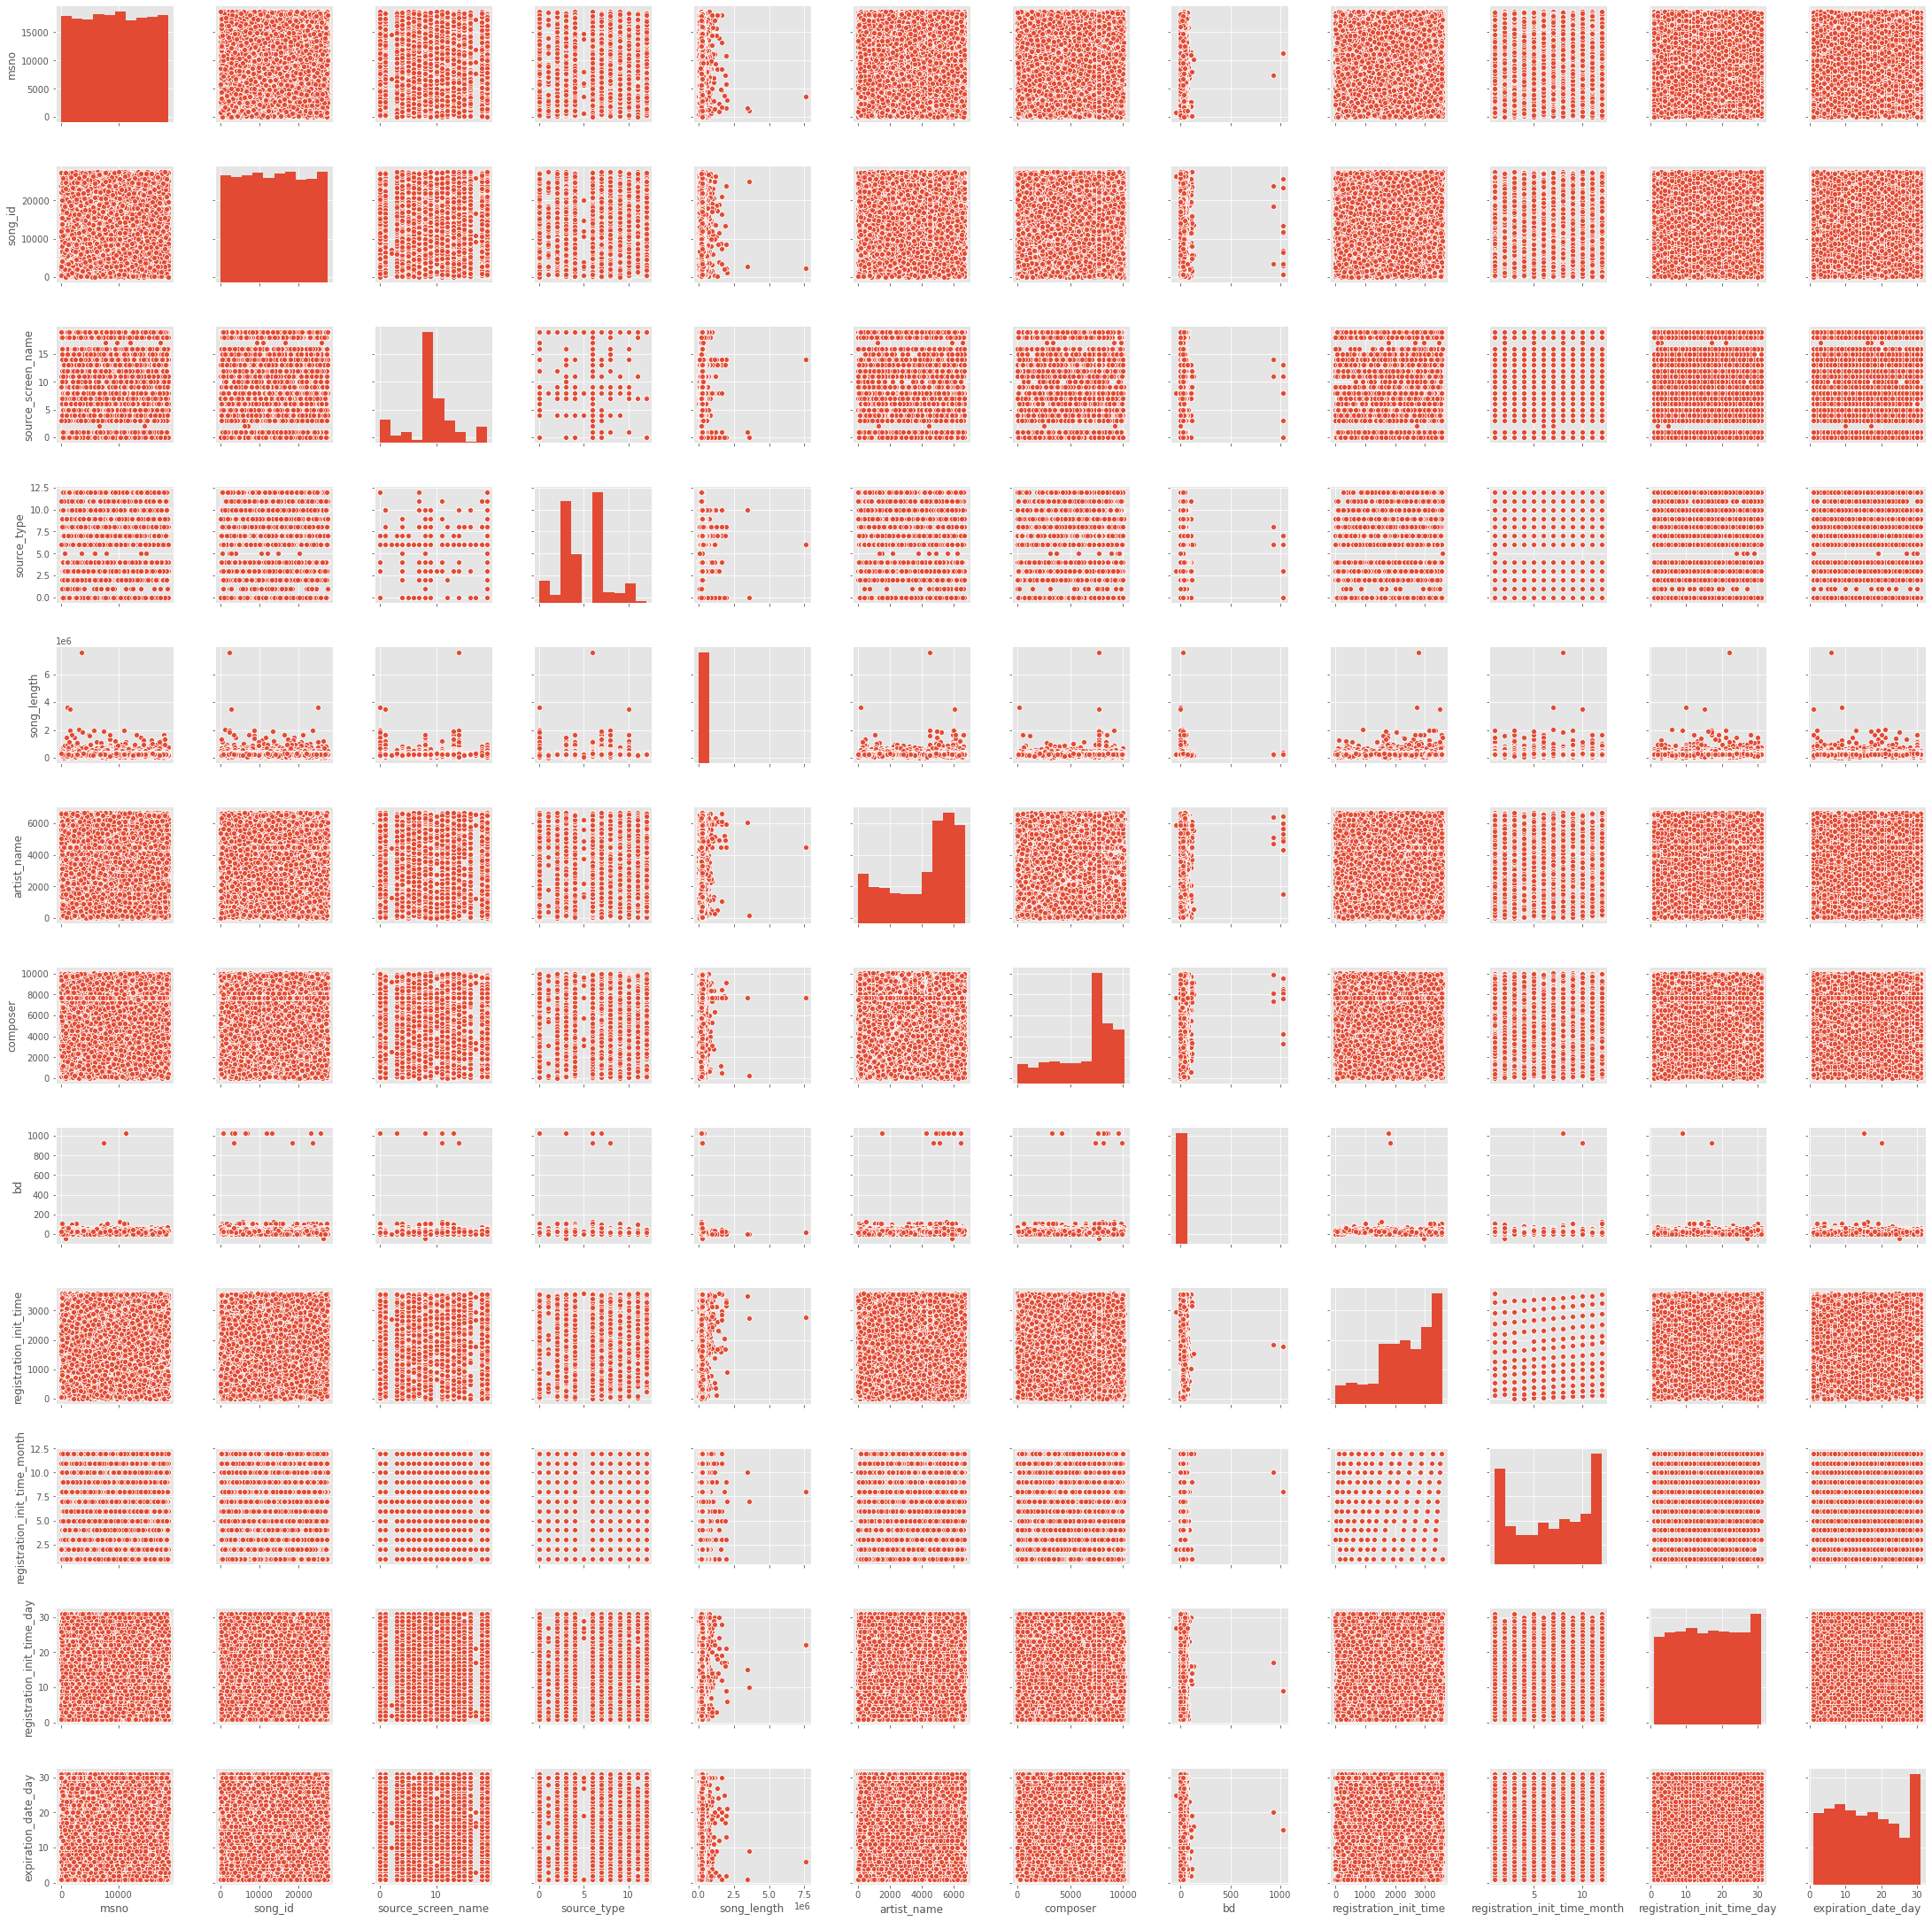

In [41]:
sns.pairplot(df)

## Random Forest

In [29]:
# Model with the best estimator
model = RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(max_depth=25, n_estimators=250)

In [30]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

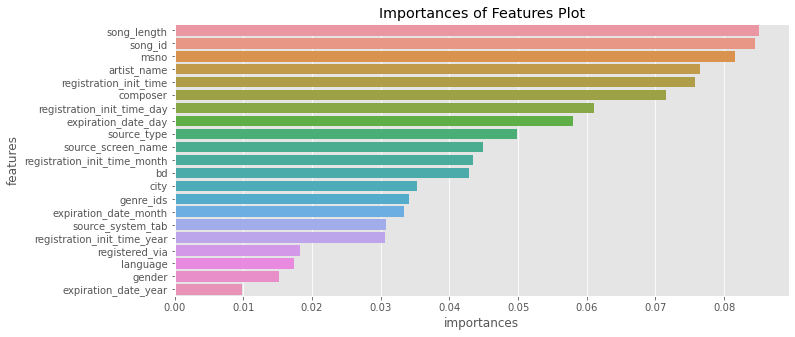

In [31]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [32]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [33]:
# Selected columns
df.columns

Index(['msno', 'song_id', 'source_screen_name', 'source_type', 'target',
       'song_length', 'artist_name', 'composer', 'bd',
       'registration_init_time', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_day'],
      dtype='object')

## XG Boost

In [34]:
import sklearn.model_selection as ms
target = df.pop('target')
x_train,x_test,y_train,y_test=ms.train_test_split(df, target,test_size=.3 ,random_state=12345678)

In [35]:
# Create model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model.fit(x_train, y_train)

[14:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
predict_labels = model.predict(x_test)

## Evaluation

In [38]:
from sklearn.metrics import classification_report

In [39]:
print(classification_report(y_test, predict_labels))

              precision    recall  f1-score   support

           0       0.62      0.59      0.61     10967
           1       0.62      0.65      0.63     11166

    accuracy                           0.62     22133
   macro avg       0.62      0.62      0.62     22133
weighted avg       0.62      0.62      0.62     22133

